In [1]:
# importing required libraries
import os
import cv2
import glob
import random
import time
import warnings
import numpy as np
import disarray as da
import seaborn as sns
import tensorflow as tf
from imutils import paths
from itertools import cycle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
#importing sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report, matthews_corrcoef

In [2]:
import os
import cv2
import glob
import random
import warnings
import numpy as np
from PIL import Image
import disarray as da
import seaborn as sns
import tensorflow as tf
from imutils import paths
from tensorflow.keras.utils import load_img, img_to_array
from itertools import cycle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

In [3]:
base_path = '/home/sanjeev/ML_Dataset/microsoft_dataset/bytes_img/'# Data Path 
img_list = glob.glob(os.path.join(base_path, '*/*.png'))

In [4]:
cur_dir = os.getcwd()
os.chdir(base_path)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(
    [f for f in os.listdir(os.getcwd()) if not f.startswith('.')], 
    key=str.lower
)
no_imgs = []  # No. of samples per family

for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
fam = []
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
        fam.append(list_fams[label])
    label += 1
num_classes = label

Label: 0	Family:           Gatak	Number of images: 1013
Label: 1	Family:    Kelihos_ver1	Number of images: 398
Label: 2	Family:    Kelihos_ver3	Number of images: 2942
Label: 3	Family:        Lollipop	Number of images: 2478
Label: 4	Family:  Obfuscator.ACY	Number of images: 1228
Label: 5	Family:          Ramnit	Number of images: 1541
Label: 6	Family:           Simda	Number of images: 42
Label: 7	Family:          Tracur	Number of images: 751
Label: 8	Family:           Vundo	Number of images: 475


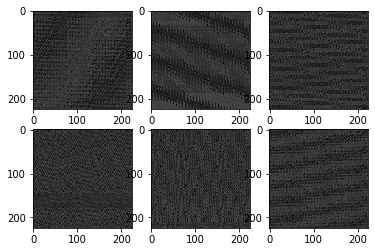

In [5]:
# Sample images from dataset
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [6]:
# width, height, channels = (224, 224, 3) #image input shape
# X = np.zeros((num_samples, width, height, channels))
# cnt = 0
# paths_list = []
# print("Processing images...")
# for i in range(len(list_fams)):
#     for img_file in glob.glob(list_fams[i]+'/*.png'):
#         paths_list.append(os.path.join(os.getcwd(),img_file))
#         img = load_img(img_file, target_size=(224, 224))
#         x = img_to_array(img) #image to array
#         x = np.expand_dims(x, axis=0)
#         x = preprocess_input(x)
#         X[cnt] = x
#         cnt += 1
# print("Images processed: %d" %(cnt))

In [6]:
#loading data
X = np.load("/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/after_research/features/processed_images_bytes.npy")
X.shape

(10868, 224, 224, 3)

In [8]:
#saving labels
# np.save("/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/after_research/features/labels.npy",y)
# labels.shape

In [7]:
#loading labels
labels = np.load("/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/after_research/features/labels.npy")
labels.shape

(10868,)

In [8]:
y_cat = to_categorical(y, num_classes=9)
y_cat.shape

(10868, 9)

In [9]:
# feature extraction
IMG_SHAPE = (224,224,3) # Input image shape
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                                       include_top=False,      # Discarding top layer of architecture 
                                                       pooling ='avg',
                                                       weights='imagenet')

In [10]:
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [11]:
model = tf.keras.Sequential([base_model, tf.keras.layers.Dense(4096, activation='relu')])
                                                                                    # Applying keras sequential layer to 
                                                                                    # base model with relu activation to 
                                                                                    # extract only features from images 
                                                                                    # without making prediction
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 1280)             4226432   
 l)                                                              
                                                                 
 dense (Dense)               (None, 4096)              5246976   
                                                                 
Total params: 9,473,408
Trainable params: 9,449,008
Non-trainable params: 24,400
_________________________________________________________________


In [12]:
%%time
#extracting features
features = model.predict(X)

CPU times: user 18min 41s, sys: 11min 13s, total: 29min 55s
Wall time: 56.4 s


In [13]:
features.shape

(10868, 4096)

In [14]:
np.save('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/after_research/features/MobileNetV3_Large_feat_bytes_microsoft_4096.npy', features)